In [2]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

In [3]:
def to_unix_time(dt):
    epoch = datetime.utcfromtimestamp(0)
    return (dt - epoch).total_seconds() * 1000

In [4]:
df = pd.read_csv("../data/PEACH/hr_device.csv")

print "total number of lines =", len(df)

excluded_macs = ["00-17-0d-00-00-b0-00-cc",
                 "00-17-0d-00-00-b0-00-aa",
                 "00-17-0d-00-00-b0-00-87",]

df_clean = df[~df.mac.isin(excluded_macs) 
            & (df.charge > 0)]

lines_removed = len(df) - len(df_clean)
print "number of lines removed = ", lines_removed, "(", lines_removed*100/len(df), "%)"

df_clean.loc[:, "date"] = pd.to_datetime(df_clean.time, unit='s')
df_clean.set_index(df_clean["date"], inplace=True)
df_clean.head()

total number of lines = 154698
number of lines removed =  18168 ( 11 %)


/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,time,mac,charge,queueOcc,numTxOk,lat,long,date
date,,,,,,,,
2016-06-20 10:11:30,1466417490,00-17-0d-00-00-30-60-ef,20686,81,40,-1.0,-1.0,2016-06-20 10:11:30
2016-06-20 10:26:30,1466418390,00-17-0d-00-00-30-60-ef,20738,49,32,-1.0,-1.0,2016-06-20 10:26:30
2016-06-20 10:41:31,1466419291,00-17-0d-00-00-30-60-ef,20789,49,32,-1.0,-1.0,2016-06-20 10:41:31
2016-06-20 11:11:31,1466421091,00-17-0d-00-00-30-60-ef,20893,49,32,-1.0,-1.0,2016-06-20 11:11:31
2016-06-20 11:26:31,1466421991,00-17-0d-00-00-30-60-ef,20944,49,32,-1.0,-1.0,2016-06-20 11:26:31


Index([u'mac', u'date', u'time', u'charge', u'queueOcc', u'numTxOk', u'lat',
       u'long', u'charge_clean'],
      dtype='object')


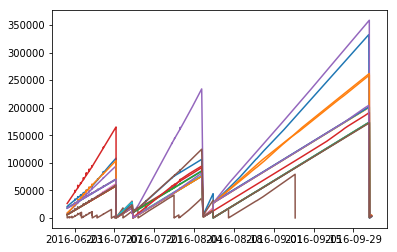

In [88]:
#for name, group in df_clean.groupby(["mac"]):
#    c = group.resample("10min").mean()
#    plt.plot(c.index, c.charge, label=name)
#plt.legend()
df_resampled = df_clean.groupby(["mac"]).resample("15min").mean().dropna().reset_index()
df_resampled.set_index(df_resampled.date, inplace=True)
#plt.plot(df_resampled)
print df_resampled.columns
for name, group in df_resampled.groupby(["mac"]):
    #print group.head()
    plt.plot(group.index, group.charge, label=name)

# Cleaning Charge


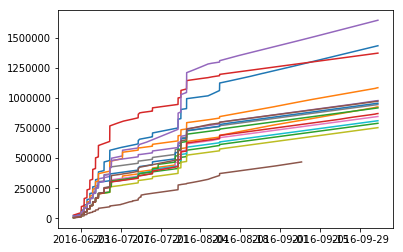

In [100]:
grouped = df_resampled.groupby(["mac"])
charge_clean = []

for name, group in grouped:
    prev_charge = 0
    new_charge = 0
    charge_max = 0
    for curr_charge in group.charge:
        if curr_charge < prev_charge:
            new_charge += curr_charge
        #elif (curr_charge > prev_charge) & ((curr_charge - prev_charge) > 40000):
        #    continue
        else:
            new_charge += (curr_charge - prev_charge)
        charge_clean.append(new_charge)
        prev_charge = curr_charge

df_resampled.loc[:, "charge_clean"] = pd.Series(charge_clean, index=df_resampled.date)

for name, group in df_resampled.groupby(["mac"]):
    plt.plot(group.index, group.charge_clean, label=name)

#plt.legend()
plt.show()

In [98]:
grouped = df_resampled.groupby(["mac"])
stats = []
charge_tot = 2821 * 3600 # charge total in mC assuming 2821mAh battery

for name, group in grouped:    
    time_diff = group.time.max() - group.time.min()
    if time_diff > 3600*24*30*2:
        charge_max = float(group.charge_clean.max())
        charge_left = charge_tot - charge_max
        time_left = float(charge_tot * time_diff) / charge_max
        stats.append([name[-8:],
                      "{:,} KC".format(int(round(charge_max)/1000)) +
                      " ({0}%) ".format(round(100*charge_max/charge_tot, 1)),
                      "{0} years".format(int(round(time_left/3600/24/365)))])
    
print pd.DataFrame(stats, columns=["MAC", "charge consumed", "lifetime"])\
    .set_index("MAC")\
    .to_latex(column_format="|c|c|c|")

\begin{tabular}{|c|c|c|}
\toprule
{} &    charge consumed & lifetime \\
MAC      &                    &          \\
\midrule
30-60-ef &  1,432 KC (14.1\%)  &  2 years \\
38-0f-66 &     924 KC (9.1\%)  &  3 years \\
3f-f8-20 &     788 KC (7.8\%)  &  4 years \\
3f-fe-87 &  1,371 KC (13.5\%)  &  2 years \\
3f-fe-88 &  1,644 KC (16.2\%)  &  2 years \\
58-32-36 &     467 KC (4.6\%)  &  5 years \\
60-01-f8 &     845 KC (8.3\%)  &  4 years \\
60-02-1b &     944 KC (9.3\%)  &  3 years \\
60-02-4b &     752 KC (7.4\%)  &  4 years \\
60-03-82 &     810 KC (8.0\%)  &  4 years \\
60-05-5f &     955 KC (9.4\%)  &  3 years \\
60-05-69 &  1,084 KC (10.7\%)  &  3 years \\
60-05-78 &     916 KC (9.0\%)  &  3 years \\
60-05-ab &     869 KC (8.6\%)  &  3 years \\
60-06-27 &     977 KC (9.6\%)  &  3 years \\
60-08-d5 &     972 KC (9.6\%)  &  3 years \\
\bottomrule
\end{tabular}

